In [2]:
from google.colab import drive,output
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip drive/MyDrive/datasets/optic_disc/archive.zip -d archive
output.clear()

In [4]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.applications.xception import preprocess_input as pi
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
!pip install git+https://github.com/tensorflow/examples.git
!pip install segmentation_models

output.clear()


In [5]:
!export SM_FRAMEWORK=tf.keras
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [6]:
img_h=300
img_w=300

In [7]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))#,cmap='gray')
    plt.axis('off')
  plt.show()

In [8]:
import glob
import cv2
import os
images_t = glob.glob("archive/B.%20Disease%20Grading/B. Disease Grading/1. Original Images/a. Training Set/*.jpg")
images_t.sort()
images_v = glob.glob("archive/B.%20Disease%20Grading/B. Disease Grading/1. Original Images/b. Testing Set/*.jpg")
images_v.sort()
train_label=pd.read_csv('archive/B.%20Disease%20Grading/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
test_label=pd.read_csv('archive/B.%20Disease%20Grading/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')
print(len(images_t))
print(len(images_v))
print(train_label.shape)
print(test_label.shape)

413
103
(413, 12)
(103, 3)


In [9]:
train_data=np.zeros((len(images_t),img_h,img_w,3))
test_data=np.zeros((len(images_v),img_h,img_w,3))

for n,id in tqdm(enumerate(images_t),total=len(images_t)):
  img=load_img(id,target_size=(img_h,img_w))#,color_mode='grayscale')
  img=img_to_array(img)
  train_data[n]=img
  train_data[n]=pi(train_data[n])
for n,id in tqdm(enumerate(images_v),total=len(images_v)):
  img=load_img(id,target_size=(img_h,img_w))#,color_mode='grayscale')
  img=img_to_array(img)
  test_data[n]=img
  test_data[n]=pi(test_data[n])

100%|██████████| 103/103 [00:07<00:00, 13.23it/s]


In [10]:
train_data.shape

(413, 300, 300, 3)

In [11]:
train_label=train_label[train_label.columns[:3]]
train_label.head()

,Image name,Retinopathy grade,Risk of macular edema
0,IDRiD_001,3,2
1,IDRiD_002,3,2
2,IDRiD_003,2,2
3,IDRiD_004,3,2
4,IDRiD_005,4,0


In [12]:
print(train_label.isnull().sum())

Image name                0
Retinopathy grade         0
Risk of macular edema     0
dtype: int64


In [13]:
train_label_retinopathy_grade=np.zeros((train_label.shape[0]))
train_label_Risk_of_macular_edema=np.zeros((train_label.shape[0]))
test_label_retinopathy_grade=np.zeros((test_label.shape[0]))
test_label_Risk_of_macular_edema=np.zeros((test_label.shape[0]))

In [14]:
for i in range(train_label.shape[0]):
  train_label_retinopathy_grade[i]=train_label['Retinopathy grade'][i]
  train_label_Risk_of_macular_edema[i]=train_label['Risk of macular edema '][i]

for i in range(test_label.shape[0]):
  test_label_retinopathy_grade[i]=test_label['Retinopathy grade'][i]
  test_label_Risk_of_macular_edema[i]=test_label['Risk of macular edema '][i]

In [15]:
from keras.utils import to_categorical

# train_data=train_data.astype("float32")/255.
# test_data=test_data.astype("float32")/255.

train_label_retinopathy_grade=to_categorical(train_label_retinopathy_grade, 5)
train_label_Risk_of_macular_edema=to_categorical(train_label_Risk_of_macular_edema, 3)
test_label_retinopathy_grade=to_categorical(test_label_retinopathy_grade, 5)
test_label_Risk_of_macular_edema=to_categorical(test_label_Risk_of_macular_edema, 3)

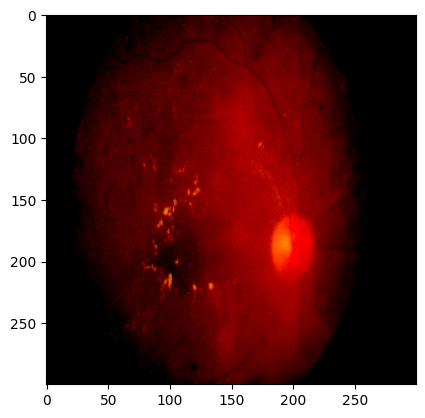

In [16]:
plt.imshow(train_data[0])

In [22]:
inputs=Input((img_h,img_w,3))
#224,224,3
s=Lambda(lambda x:x/255)(inputs)
c1=Conv2D(16,3,padding='same',activation='relu')(s)
c1=Conv2D(16,3,padding='same',activation='relu')(c1)
c1=Dropout(0.2)(c1)
    #downsample
p1=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c1)
#112,112,16
c2=Conv2D(32,3,padding='same',activation='relu')(p1)
c2=Conv2D(32,3,padding='same',activation='relu')(c2)
c2=Conv2D(32,3,padding='same',activation='relu')(c2)
c2=Dropout(0.2)(c2)
    #downsample
p2=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c2)
#56,56,32
c3=Conv2D(64,3,padding='same',activation='relu')(p2)
c3=Conv2D(64,3,padding='same',activation='relu')(c3)
c3=Conv2D(64,3,padding='same',activation='relu')(c3)
c3=Dropout(0.2)(c3)
    #downsample
p3=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c3)
#28,28,64
c4=Conv2D(128,3,padding='same',activation='relu')(p3)
c4=Conv2D(128,3,padding='same',activation='relu')(c4)
c4=Conv2D(128,3,padding='same',activation='relu')(c4)
c4=Dropout(0.2)(c4)
    #downsample
p4=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c4)
#14,14,128
# c5=Conv2D(256,3,padding='same',activation='relu')(p4)
# c5=Conv2D(256,3,padding='same',activation='relu')(c5)
# c5=Conv2D(256,3,padding='same',activation='relu')(c5)
# c5=Dropout(0.2)(c5)
# c6=Conv2D(1,(1,1),activation='sigmoid')(c5)
c6=Flatten()(c4)
outputs=Dense(5,activation='softmax')(c6)
    # Flatten(),
    # Dense(1,activation='softmax')

model=Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics = ['binary_accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC(),sm.metrics.IOUScore(),sm.metrics.FScore()])# tf.keras.utils.plot_model(model, show_shapes=True)

# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 300, 300, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 300, 300, 16)      2320      
                                                                 
 dropout_1 (Dropout)         (None, 300, 300, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                             

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
mp=ModelCheckpoint('best_seg model.h5',save_best_only=True,monitor='val_accuracy')
call=[mp]


model.fit(
    train_data,
    train_label_retinopathy_grade,
    validation_data=(test_data,test_label_retinopathy_grade),
    batch_size=1,
    # steps_per_epoch=100,
    epochs=20,
    callbacks=call
)

Epoch 1/20
413/413 [==============================] - 12s 13ms/step - loss: 1.4922 - accuracy: 0.3317 - val_loss: 1.4570 - val_accuracy: 0.3301
Epoch 2/20
413/413 [==============================] - 4s 10ms/step - loss: 1.4587 - accuracy: 0.3196 - val_loss: 1.4518 - val_accuracy: 0.3301
Epoch 3/20
413/413 [==============================] - 5s 12ms/step - loss: 1.4638 - accuracy: 0.3075 - val_loss: 1.4517 - val_accuracy: 0.3107
Epoch 4/20
413/413 [==============================] - 5s 11ms/step - loss: 1.4570 - accuracy: 0.3317 - val_loss: 1.4768 - val_accuracy: 0.3107
Epoch 5/20
413/413 [==============================] - 5s 12ms/step - loss: 1.4548 - accuracy: 0.3027 - val_loss: 1.4509 - val_accuracy: 0.3107
Epoch 6/20
413/413 [==============================] - 5s 13ms/step - loss: 1.4440 - accuracy: 0.3608 - val_loss: 1.4728 - val_accuracy: 0.3107
Epoch 7/20
413/413 [==============================] - 5s 11ms/step - loss: 1.4622 - accuracy: 0.3075 - val_loss: 1.4525 - val_accuracy: 0.310

----------XCEPTION MODEL----------

In [18]:
from keras.applications.xception import Xception

x_base_model = Xception(input_shape = (img_h,img_w,3),  weights='imagenet',include_top=False)
xception_model=Sequential()
xception_model.add(x_base_model)
xception_model.add(GlobalAveragePooling2D())
xception_model.add(Dropout(0.3))
xception_model.add(Flatten())
xception_model.add(Dense(5, activation='softmax'))
xception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20871725 (79.62 MB)
Trainable params: 20817197 (79.41 MB)
Non-trainable params: 54528 (213.00 KB)
__________

In [19]:
checkpoint_path = "Xception/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
xception_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
# xception_model.load_weights(checkpoint_path)

In [21]:
xception_model.fit(
    train_data,
    train_label_retinopathy_grade,
    validation_data=(test_data,test_label_retinopathy_grade),
    batch_size=1,
    # steps_per_epoch=100,
    epochs=5,
    callbacks=call
)

Epoch 1/5
413/413 [==============================] - 18s 44ms/step - loss: 0.0851 - accuracy: 0.9806 - val_loss: 2.2155 - val_accuracy: 0.4466
Epoch 2/5
413/413 [==============================] - 17s 42ms/step - loss: 0.0422 - accuracy: 0.9903 - val_loss: 2.5963 - val_accuracy: 0.4854
Epoch 3/5
413/413 [==============================] - 17s 41ms/step - loss: 0.0236 - accuracy: 0.9952 - val_loss: 2.4325 - val_accuracy: 0.4175
Epoch 4/5
413/413 [==============================] - 16s 40ms/step - loss: 0.0271 - accuracy: 0.9927 - val_loss: 2.8087 - val_accuracy: 0.4660
Epoch 5/5
413/413 [==============================] - 17s 40ms/step - loss: 0.0198 - accuracy: 0.9927 - val_loss: 3.0883 - val_accuracy: 0.4466


In [26]:
from keras.applications.inception_v3 import InceptionV3

checkpoint_path = "drive/MyDrive/ML_CKPT/InceptionV3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 25,restore_best_weights = True,verbose = 2)  #'''min_delta = 1,patience = 20,'''

base_model = InceptionV3(input_shape = (img_h,img_w,3),  weights='imagenet',include_top=False)
Inception_model=Sequential()
Inception_model.add(base_model)
Inception_model.add(GlobalAveragePooling2D())
Inception_model.add(Dropout(0.3))
Inception_model.add(Dense(5, activation='softmax'))
Inception_model.summary()
Inception_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

Inception_model.fit(
    train_data,
    train_label_retinopathy_grade,
    validation_data=(test_data,test_label_retinopathy_grade),
    batch_size=1,
    # steps_per_epoch=100,
    epochs=7,
    callbacks=call
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 21778597 (83.08 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________
Epoch 1/7
412/413 [============================>.] - ETA: 0s - loss: 1.524

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


413/413 [==============================] - 62s 72ms/step - loss: 1.5228 - accuracy: 0.3462 - val_loss: 1.4414 - val_accuracy: 0.3981
Epoch 2/7
413/413 [==============================] - 21s 50ms/step - loss: 1.3358 - accuracy: 0.4818 - val_loss: 1.9911 - val_accuracy: 0.3398
Epoch 3/7
413/413 [==============================] - 22s 54ms/step - loss: 1.1479 - accuracy: 0.5375 - val_loss: 2.3962 - val_accuracy: 0.3981
Epoch 4/7
413/413 [==============================] - 21s 51ms/step - loss: 0.9840 - accuracy: 0.5956 - val_loss: 1.9183 - val_accuracy: 0.3495
Epoch 5/7
413/413 [==============================] - 22s 52ms/step - loss: 0.7597 - accuracy: 0.6852 - val_loss: 2.3195 - val_accuracy: 0.3786
Epoch 6/7
413/413 [==============================] - 20s 49ms/step - loss: 0.5169 - accuracy: 0.7966 - val_loss: 3.9913 - val_accuracy: 0.3981
Epoch 7/7
413/413 [==============================] - 22s 53ms/step - loss: 0.2856 - accuracy: 0.8959 - val_loss: 4.0643 - val_accuracy: 0.3592


In [30]:
# from keras.applications.vgg16 import VGG16

# checkpoint_path = "drive/MyDrive/ML_CKPT/InceptionV3/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)
# early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 25,restore_best_weights = True,verbose = 2)  #'''min_delta = 1,patience = 20,'''

# base_model = VGG16(input_shape = (img_h,img_w,3),  weights='imagenet',include_top=False)
# VGG16_model=Sequential()
# VGG16_model.add(base_model)
# VGG16_model.add(GlobalAveragePooling2D())
# VGG16_model.add(Dropout(0.3))
# VGG16_model.add(Dense(5, activation='softmax'))
# VGG16_model.summary()
# VGG16_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

VGG16_model.fit(
    train_data,
    train_label_retinopathy_grade,
    validation_data=(test_data,test_label_retinopathy_grade),
    batch_size=1,
    # steps_per_epoch=100,
    epochs=7,
    callbacks=call
)

Epoch 1/7
413/413 [==============================] - 20s 48ms/step - loss: 1.3264 - accuracy: 0.5448 - val_loss: 1.6247 - val_accuracy: 0.3495
Epoch 2/7
413/413 [==============================] - 21s 51ms/step - loss: 1.2880 - accuracy: 0.5424 - val_loss: 1.3201 - val_accuracy: 0.4951
Epoch 3/7
413/413 [==============================] - 19s 47ms/step - loss: 1.5035 - accuracy: 0.5278 - val_loss: 1.5472 - val_accuracy: 0.5340
Epoch 4/7
413/413 [==============================] - 21s 50ms/step - loss: 1.3055 - accuracy: 0.5327 - val_loss: 2.0908 - val_accuracy: 0.5437
Epoch 5/7
413/413 [==============================] - 20s 48ms/step - loss: 1.4242 - accuracy: 0.6077 - val_loss: 1.4086 - val_accuracy: 0.5243
Epoch 6/7
413/413 [==============================] - 20s 47ms/step - loss: 1.5168 - accuracy: 0.5763 - val_loss: 1.6388 - val_accuracy: 0.4757
Epoch 7/7
413/413 [==============================] - 21s 50ms/step - loss: 1.5113 - accuracy: 0.5351 - val_loss: 1.8600 - val_accuracy: 0.5049